In [1]:
import json
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from advertools import url_to_df
from matplotlib.ticker import LinearLocator
from statsmodels.tsa.stattools import acf, pacf

BROWSING_HISTORY_JSON = 'data/BrowserHistory.json'
LABELS_JSON = 'data/WordbagsLabels.json'

# Timeseries

We ought to construct a timeseries from the labeled data and later conduct analysis of it.

In the importing and preparation part the data will be transformed into pandas's series datatype with time indexing in epoch time (although displaying it in readable format later) and an range of 0 to 2 as the value. We can associate 2 with learning, 1 with laisure and 0 with miscellaneous. During the preparation we'll also need to manually label the few lacking sites. Later, using the original dataframe of the browsing history we'll replace the outliers we excluded during pre-clustering preparation and fill the gaps with repetition of the last page visited.

The data will be aggregated into 10 minutes intervals, with every value being set to the most common label occuring in the timespan, making it 6*24 = 144 points per day.

When it comes to the analysis part, I plan to check out for cyclicality in the span of a day and a week with the use of Partial Autocorrelation Function.

## Preparing labels
According to the mentioned issue, we have to manually label ylilauta.org, cytu.be and www.postgresqltutorial.com as Laisure, Laisure and Learning accordingly and translate it to numbers.

In [2]:
labels_df = pd.read_json(open(LABELS_JSON, encoding='utf-8'))

update = pd.DataFrame({'netloc': ['ylilauta.org', 'cytu.be', 'www.postgresqltutorial.com'],
                       'label' : ['Laisure', 'Laisure', 'Learning']})

labels_s = pd.concat([labels_df, update], axis=0, ignore_index=True).set_index('netloc')['label']
labels_s = labels_s.map({'Learning' : 2,
                         'Laisure' : 1,
                         'Miscellaneous' : 0})

## Creating the series

We again cut the data at the specified point in time (19.10.2021), we later transform it from epoch counted in microseconds to a more convinient pandas datetime type.
Then we again gather the domain names and create the history_s series by selecting the 'time_usec' column as its key, and 'netloc' as the value. Then we finally map the domain to the label via .map() method creating the s1 series, which we later aggregate in the way specified at the beginning.

In [3]:
history_df = pd.json_normalize(json.load(open(BROWSING_HISTORY_JSON, encoding='utf-8')), record_path=['Browser History'])
history_df.drop(history_df[history_df['time_usec'] < 1634601600000000].index, inplace=True)
history_df['time_usec'] = pd.to_datetime(history_df['time_usec'], unit='us')
history_df = history_df.join(url_to_df(history_df['url'])[['netloc']])

history_s = history_df.set_index('time_usec')['netloc'].sort_index(ascending=True)
history_s = history_s[history_s.isin(labels_s.index)]

In [4]:
s1 = history_s.map(labels_s)

In [ ]:
span = 10 # Aggregation timespan in minutes

# The pd.mode() cannot be used for resample method, so we substitute it with a similar one from scipy.stats.
# It returns a touple of lists ([modes], [amounts])
s2 = s1.resample(f'{span}min', label='left').apply(lambda x : stats.mode(x)[0] if stats.mode(x)[0] or stats.mode(x)[0]==0  else np.nan)
s2.fillna(method='ffill', inplace=True)

## ACF and PACF

We use the autocorrelation functions to determine the behaviour of our series. We then visualise them.

In [34]:
nlags = 6*6 # The amount of 10 lags we want to look at. 

acf_vals = acf(s2, nlags=nlags)
pacf_vals = pacf(s2, nlags=nlags)

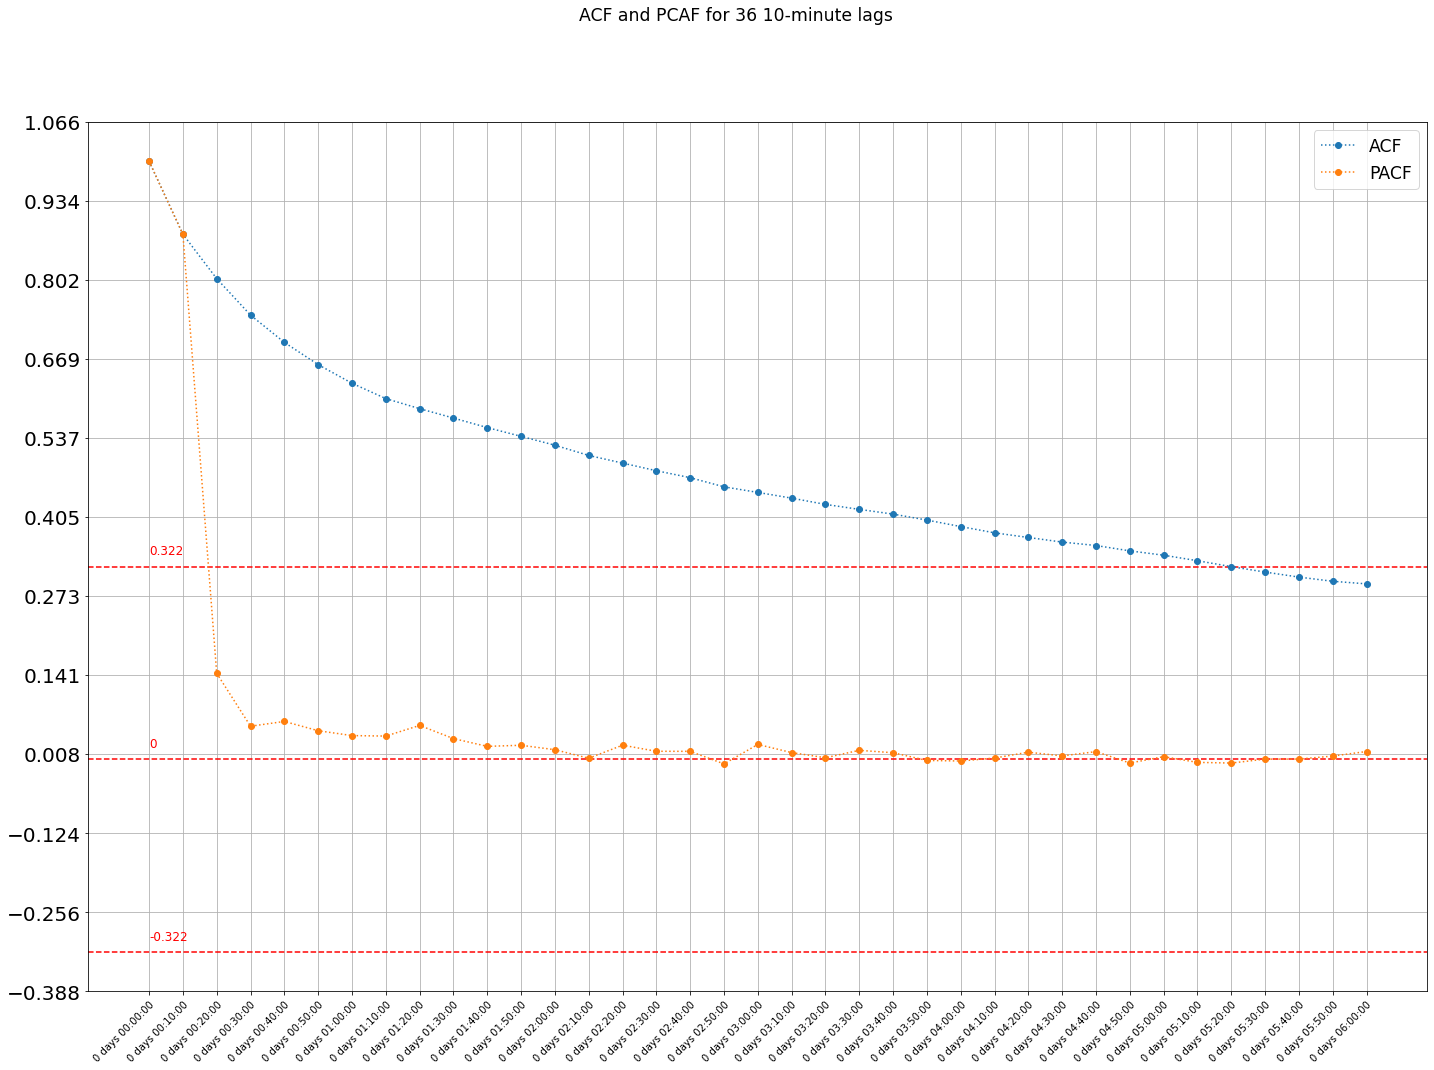

In [50]:
# The threshold of importance around zero.
# The +1 term conpensates for the first term of no-lag correlation
epsilon = 1.96/np.sqrt(nlags+1) 

fig, ax = plt.subplots(figsize=(24, 16))

ax.set_xticks(np.arange(nlags+1)) 
ax.set_xticklabels([str(pd.Timedelta(f'{x*span}m')) for x in range(nlags+1)])
ax.tick_params(top=False, bottom=True,
               labeltop=False, labelbottom=True)
plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')


plt.yticks(fontsize = 20) 
ax.get_yaxis().set_major_locator(LinearLocator(numticks=12))

plt.axhline(y=epsilon, linestyle='--', color='red')
plt.axhline(y=0, linestyle='--', color='red')
plt.axhline(y=-epsilon, linestyle='--', color='red')
plt.text(0.0, 0.02, '0', color='red', size='large')
plt.text(0.0, epsilon + 0.02, f'{round(epsilon,3)}', color='red', size='large')
plt.text(0.0, -epsilon + 0.02, f'-{round(epsilon,3)}', color='red', size='large')

acf_line, = plt.plot(range(nlags+1), acf_vals, linestyle=':', marker='o', label='ACF') 
pacf_line, = plt.plot(range(nlags+1), pacf_vals, linestyle=':', marker='o', label='PACF') 
ax.legend(handles=[acf_line, pacf_line], prop={'size' :'xx-large'})

fig.suptitle(f'ACF and PCAF for {nlags} {span}-minute lags', fontsize='xx-large')
plt.grid()
plt.show()